# Marketing Analytics FA 2020 Final Project - Movid

### Kun Liu, kl2522

### Part 1 - A/B Testing

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import datetime

# load the data and pre-processing the dates
df = pd.read_csv('subscribers.csv')
df.account_creation_date = pd.to_datetime(df.account_creation_date, format='%Y-%m-%d')
df.account_creation_date = df.account_creation_date.apply(lambda x: datetime.date(year=x.year, month=x.month, day=x.day))

# add the effectiveness flag (payment_period > 0)
df['mkt_effective_TF'] = df.payment_period.apply(lambda x: 1 if x>0 else 0)

# set test_1 and test_2 date account creation date range
test_1_start_date = datetime.date(year=2019, month=11, day=1)
test_1_end_date = datetime.date(year=2019, month=12, day=1)

test_2_start_date = datetime.date(year=2019, month=7, day=1)
test_2_end_date = datetime.date(year=2019, month=12, day=1)

In [2]:
# slice the data for the respective tests
df_test1 = df.loc[(
                  (df['plan_type'] == 'base_uae_14_day_trial')|(df['plan_type'] == 'high_uae_14_day_trial')
                  ) & 
                  (df['account_creation_date'] >= test_1_start_date) &
                  (df['account_creation_date'] < test_1_end_date),
                  ['subid', 'plan_type', 'account_creation_date', 'mkt_effective_TF']]

df_test2 = df.loc[(
                  (df['plan_type'] == 'base_uae_14_day_trial')|(df['plan_type'] == 'low_uae_no_trial')
                  ) & 
                  (df['account_creation_date'] >= test_2_start_date) &
                  (df['account_creation_date'] < test_2_end_date),
                  ['subid', 'plan_type', 'account_creation_date', 'mkt_effective_TF']]

In [3]:
# for A/B test calculation
def calc_proportion(array_TF):
    return sum(array_TF)/len(array_TF)

def calc_zscore(phat_f, nhat_f, p_f, n_f=1, num_samples_f=1, two_sample_diff_f=0):
    print('Conducting test assuming %d samples' % num_samples_f)
    print('z = ((%3.3f - %3.3f) - %d)/std_error' % (phat_f, p_f, two_sample_diff_f))
    return ((phat_f - p_f) - two_sample_diff_f)/calc_standard_error(p_f, n_f, phat_f, nhat_f, num_samples_f)

def get_p_value(zscore_f, num_sides_f):
    return 1 - ((1-norm.cdf(abs(zscore_f))) * num_sides_f)

def get_z_crit_value(alpha_f, num_sides_f):
    return norm.ppf(1-(alpha_f/num_sides_f))

def calc_standard_error(p_f, n_f, phat_f, nhat_f, num_samples_f=1):
    # if we assume one sample (Variant B) and Variant A as baseline = population, p_f and n_f are variant A stats
    if num_samples_f == 1:
        std_err_f = np.sqrt(p_f*(1-p_f)/nhat_f)
        print('Std err for %d sample test: \nnp.sqrt(%3.3f * (1 - %3.3f)/ %d) = %3.4f' % (num_samples_f, p_f, p_f, nhat_f, std_err_f))
        return std_err_f
    # if we assume two samples (Variant A and Variant B both), p_f, n_f, phat_f, nhat_f are the values for each sample
    if num_samples_f == 2:
        std_err_f = np.sqrt((p_f*(1-p_f)/n_f) + (phat_f * (1-phat_f) / nhat_f))
        print('Std err for %d sample test: \nnp.sqrt((%3.3f*(1-%3.3f)/%d) + (%3.3f * (1-%3.3f) / %d))' % (num_samples_f, p_f, p_f, n_f, phat_f, phat_f, nhat_f))
        return std_err_f

def reject_null(variantA_outcomes_f, variantB_outcomes_f, alpha_f, num_sides_f, num_samples_f):
    phat_f = calc_proportion(variantB_outcomes_f)
    nhat_f = len(variantB_outcomes_f)
    p_f = calc_proportion(variantA_outcomes_f)
    n_f = len(variantA_outcomes_f)
    print('Proportion 1 (Variant A): %2.3f (%d obs)' % (p_f, n_f))
    print('Proportion 2 (Variant B): %2.3f (%d obs)' % (phat_f, nhat_f))
    z_score_f = calc_zscore(phat_f, nhat_f, p_f, n_f, num_samples_f)
    p_value_f = get_p_value(z_score_f, num_sides_f)
    z_crit_f = get_z_crit_value(alpha_f, num_sides_f)

    return z_score_f > z_crit_f, z_score_f, p_value_f

In [4]:
# Test 1

# set parameters
alpha = 0.05
num_sides = 1
num_samples = 2
variantA_outcomes = df_test1.loc[df_test1['plan_type'] == 'base_uae_14_day_trial', 'mkt_effective_TF']
variantB_outcomes = df_test1.loc[df_test1['plan_type'] == 'high_uae_14_day_trial', 'mkt_effective_TF']

# run tests
reject_null_test, z_score, p_value = reject_null(df_test1.loc[(df_test1['plan_type'] == 'base_uae_14_day_trial'), 'mkt_effective_TF'],
                                                 df_test1.loc[(df_test1['plan_type'] == 'high_uae_14_day_trial'), 'mkt_effective_TF'],
                                                 alpha, num_sides, num_samples)

print('For %d-sided, %d-sample test, reject null T/F?: %s' % (num_sides, num_samples, reject_null_test))
print('z-score = %3.3f and p-value = %3.1f%%' % (z_score, p_value*100))

Proportion 1 (Variant A): 0.683 (26493 obs)
Proportion 2 (Variant B): 0.658 (325 obs)
Conducting test assuming 2 samples
z = ((0.658 - 0.683) - 0)/std_error
Std err for 2 sample test: 
np.sqrt((0.683*(1-0.683)/26493) + (0.658 * (1-0.658) / 325))
For 1-sided, 2-sample test, reject null T/F?: False
z-score = -0.942 and p-value = 82.7%


In [5]:
# Test 2

# set parameters
alpha = 0.05
num_sides = 1
num_samples = 2
variantA_outcomes = df_test2.loc[df_test2['plan_type'] == 'base_uae_14_day_trial', 'mkt_effective_TF']
variantB_outcomes = df_test2.loc[df_test2['plan_type'] == 'low_uae_no_trial', 'mkt_effective_TF']

# run tests
reject_null_test, z_score, p_value = reject_null(df_test2.loc[(df_test2['plan_type'] == 'base_uae_14_day_trial'), 'mkt_effective_TF'],
                                                 df_test2.loc[(df_test2['plan_type'] == 'low_uae_no_trial'), 'mkt_effective_TF'],
                                                 alpha, num_sides, num_samples)

print('For %d-sided, %d-sample test, reject null T/F?: %s' % (num_sides, num_samples, reject_null_test))
print('z-score = %3.3f and p-value = %3.1f%%' % (z_score, p_value*100))

Proportion 1 (Variant A): 0.563 (120050 obs)
Proportion 2 (Variant B): 0.527 (167 obs)
Conducting test assuming 2 samples
z = ((0.527 - 0.563) - 0)/std_error
Std err for 2 sample test: 
np.sqrt((0.563*(1-0.563)/120050) + (0.527 * (1-0.527) / 167))
For 1-sided, 2-sample test, reject null T/F?: False
z-score = -0.924 and p-value = 82.2%


### Part 2 - Customer Segmentation & Targeting

In [6]:
# ---------- called again just in case ----------
import pandas as pd

# load the data and pre-processing the dates
df = pd.read_csv('subscribers.csv')

# add the effectiveness flag (payment_period > 0)
df['mkt_effective_TF'] = df.payment_period.apply(lambda x: 1 if x>0 else 0)

In [7]:
df.columns

Index(['Unnamed: 0', 'subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'age', 'male_TF', 'country',
       'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'trial_end_date',
       'initial_credit_card_declined', 'join_fee', 'language', 'payment_type',
       'num_trial_days', 'current_sub_TF', 'payment_period', 'last_payment',
       'next_payment', 'cancel_date', 'trial_completed', 'mkt_effective_TF'],
      dtype='object')

In [8]:
# get the fee-paying current user group with key variables for analysis
df_seg = df.loc[(df['current_sub_TF'] == True) & (df['mkt_effective_TF'] == 1),
                ['subid', 'package_type', 'num_weekly_services_utilized', 
                 'preferred_genre', 'intended_use', 'weekly_consumption_hour', 
                 'num_ideal_streaming_services', 'age', 'male_TF', 'op_sys',
                 'initial_credit_card_declined']]

In [9]:
# define functions for data cleaning (categorizations)

def OTT_utilized(number):
    if number == 'Average_OTT':
        return('Average_OTT')
    else:
        number = int(number)
        if number >= 0 and number <= 2:
            return('Low_OTT')
        elif number >= 3 and number <= 5:
            return('Average_OTT')
        else: 
            return('High_OTT')

def hours_consumed(number):
    if number == 'Average_Consumption':
        return('Average_Consumption')
    else:
        number = int(number)
        if number < 21:
            return('Light_Consumption')
        elif number >= 21 and number < 35:
            return('Average_Consumption')
        else: 
            return('High_Consumption')

def straeming_service(number):
    if number == 'Average_Streaming':
        return('Average_Streaming')
    else:
        number = int(number)
        if number <= 1:
            return('Low_Streaming')
        elif number == 2:
            return('Average_Streaming')
        else: 
            return('High_Streaming')
        
def age_range(number):
    if number == 'Mid_age':
        return('Mid_age')
    else:
        number = int(number)
        if number > 1900 and number < 2020:
            number = 2020 - number
        else:
            pass
        if number <= 30:
            return('Young')
        elif number > 30 and number < 60:
            return('Mid_age')
        else: 
            return('Senior')

In [10]:
## data cleaning
# 1. "package_type" (fill_na)
df_seg['package_type'] = df_seg['package_type'].fillna('no_package')

# 2. "num_weekly_services_utilized" (fill_na & categorization)
df_seg['num_weekly_services_utilized'] = df_seg['num_weekly_services_utilized'].fillna('Average_OTT')
df_seg['OTT_utilized'] = df_seg['num_weekly_services_utilized'].apply(OTT_utilized)

# 3. "preferred_genre" (fill_na)
df_seg['preferred_genre'] = df_seg['preferred_genre'].fillna('no_genre_preference')

# 4. "intended_use" (fill_na)
df_seg['intended_use'] = df_seg['intended_use'].fillna('no_intended_use')

# 5. "weekly_consumption_hour" (fill_na & categorization)
df_seg['weekly_consumption_hour'] = df_seg['weekly_consumption_hour'].fillna('Average_Consumption')
df_seg['Consumption_pattern'] = df_seg['weekly_consumption_hour'].apply(hours_consumed)

# 6. "num_ideal_streaming_services" (fill_na & categorization)
df_seg['num_ideal_streaming_services'] = df_seg['num_ideal_streaming_services'].fillna('Average_Streaming')
df_seg['Streaming_pattern'] = df_seg['num_ideal_streaming_services'].apply(straeming_service)

# 7. "age" (fill_na & categorization)
df_seg['age'] = df_seg['age'].fillna('Mid_age')
df_seg['Age_group'] = df_seg['age'].apply(age_range)

# 8. "male_TF" (fill_na)
df_seg['male_TF'] = df_seg['male_TF'].fillna(False)

# 9. "op_sys" (fill_na)
df_seg['op_sys'] = df_seg['op_sys'].fillna('Other')

In [11]:
# consolidate all the data pre-processing results
df_seg_clean = df_seg[['subid', 'package_type', 'preferred_genre', 'intended_use', 
                       'male_TF', 'op_sys', 'initial_credit_card_declined', 'OTT_utilized',
                       'Consumption_pattern', 'Streaming_pattern', 'Age_group']]

df_seg_clean = df_seg_clean.set_index('subid')

In [12]:
# transform categorical variables into dummy variables
df_seg_clean = pd.get_dummies(df_seg_clean)
df_seg_clean.columns

Index(['male_TF', 'initial_credit_card_declined', 'package_type_base',
       'package_type_economy', 'package_type_enhanced',
       'package_type_no_package', 'preferred_genre_comedy',
       'preferred_genre_drama', 'preferred_genre_international',
       'preferred_genre_no_genre_preference', 'preferred_genre_other',
       'preferred_genre_regional', 'intended_use_access to exclusive content',
       'intended_use_education', 'intended_use_expand international access',
       'intended_use_expand regional access', 'intended_use_no_intended_use',
       'intended_use_other', 'intended_use_replace OTT',
       'intended_use_supplement OTT', 'op_sys_Android', 'op_sys_Other',
       'op_sys_iOS', 'OTT_utilized_Average_OTT', 'OTT_utilized_High_OTT',
       'OTT_utilized_Low_OTT', 'Consumption_pattern_Average_Consumption',
       'Consumption_pattern_High_Consumption',
       'Consumption_pattern_Light_Consumption',
       'Streaming_pattern_Average_Streaming',
       'Streaming_pattern

In [13]:
# import the required functions for K-Means model
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

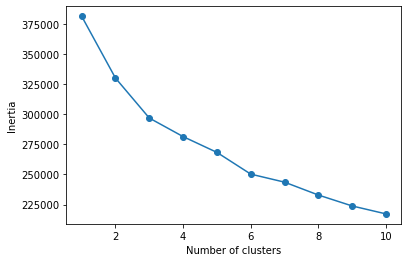

In [14]:
# decide the best k: inertia criterion
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='random', n_init=10, max_iter=200, tol=1e-04, random_state=777)
    kmeans.fit(df_seg_clean)
    inertia.append(kmeans.inertia_)

# plot
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [15]:
# Clustering model
kmeans = KMeans(n_clusters=3, init='random', random_state=777)

kmeans.fit(df_seg_clean)

full_cluster_kmeans = kmeans.predict(df_seg_clean)

df_seg_clean['cluster_kmeans'] = full_cluster_kmeans

In [16]:
# check cluster proportions
for i in [0,1,2]:
    print('Cluster {} has {} customers.'.format(i, df_seg_clean['cluster_kmeans'].value_counts()[i]))

Cluster 0 has 38324 customers.
Cluster 1 has 37929 customers.
Cluster 2 has 45147 customers.


In [17]:
# check out the clusters in data set
df_seg_clean.groupby(by='cluster_kmeans').mean().T

cluster_kmeans,0,1,2
male_TF,0.113010,0.109758,0.091457
initial_credit_card_declined,0.054796,0.054075,0.043680
package_type_base,0.000000,0.562446,1.000000
package_type_economy,0.099468,0.066361,0.000000
package_type_enhanced,0.810980,0.325503,0.000000
package_type_no_package,0.089552,0.045691,0.000000
preferred_genre_comedy,0.709999,0.699017,0.752298
preferred_genre_drama,0.125900,0.178676,0.180078
preferred_genre_international,0.021136,0.032561,0.023634
preferred_genre_no_genre_preference,0.091796,0.047905,0.002392


### Part 3 - User Churn Analysis

In [18]:
import numpy as np
import pandas as pd
import datetime

# load the data and pre-processing the dates
df = pd.read_csv('subscribers.csv')

# add the effectiveness flag (payment_period > 0)
df['mkt_effective_TF'] = df.payment_period.apply(lambda x: 1 if x>0 else 0)

In [19]:
# add the effectiveness flag (payment_period > 0)
df['churn_TF'] = df.current_sub_TF.apply(lambda x: 1 if x == False else 0)

In [20]:
# get the fee-paying user group with key variables for analysis
df_chr = df.loc[(df['trial_completed'] == True) & (df['mkt_effective_TF'] == 1),
                ['subid', 'package_type', 'num_weekly_services_utilized',
                 'weekly_consumption_hour', 'num_ideal_streaming_services', 
                 'age', 'initial_credit_card_declined', 'churn_TF']]

In [21]:
# define the functions for categorization
def OTT_utilized(number):
    if number == 'Average_OTT':
        return('Average_OTT')
    else:
        number = int(number)
        if number >= 0 and number <= 2:
            return('Low_OTT')
        elif number >= 3 and number <= 5:
            return('Average_OTT')
        else: 
            return('High_OTT')
        
def hours_consumed(number):
    if number == 'Average_Consumption':
        return('Average_Consumption')
    else:
        number = int(number)
        if number < 21:
            return('Light_Consumption')
        elif number >= 21 and number < 35:
            return('Average_Consumption')
        else: 
            return('High_Consumption')

def straeming_service(number):
    if number == 'Average_Streaming':
        return('Average_Streaming')
    else:
        number = int(number)
        if number <= 1:
            return('Low_Streaming')
        elif number == 2:
            return('Average_Streaming')
        else: 
            return('High_Streaming')

def age_range(number):
    if number == 'Mid_age':
        return('Mid_age')
    else:
        number = int(number)
        if number > 1900 and number < 2020:
            number = 2020 - number
        else:
            pass
        if number <= 30:
            return('Young')
        elif number > 30 and number < 60:
            return('Mid_age')
        else: 
            return('Senior')

In [22]:
# data cleaning
# 1. "package_type" (fill_na)
df_chr['package_type'] = df_chr['package_type'].fillna('no_package')

# 2. "num_weekly_services_utilized" (fill_na & categorization)
df_chr['num_weekly_services_utilized'] = df_chr['num_weekly_services_utilized'].fillna('Average_OTT')
df_chr['OTT_utilized'] = df_chr['num_weekly_services_utilized'].apply(OTT_utilized)

# 3. "weekly_consumption_hour" (fill_na & categorization)
df_chr['weekly_consumption_hour'] = df_chr['weekly_consumption_hour'].fillna('Average_Consumption')
df_chr['Consumption_pattern'] = df_chr['weekly_consumption_hour'].apply(hours_consumed)

# 4. "num_ideal_streaming_services" (fill_na & categorization)
df_chr['num_ideal_streaming_services'] = df_chr['num_ideal_streaming_services'].fillna('Average_Streaming')
df_chr['Streaming_pattern'] = df_chr['num_ideal_streaming_services'].apply(straeming_service)

# 5. "age" (fill_na & categorization)
df_chr['age'] = df_chr['age'].fillna('Mid_age')
df_chr['Age_group'] = df_chr['age'].apply(age_range)

In [23]:
# consolidate all the data pre-processing results
df_chr_clean = df_chr[['subid', 'package_type', 'initial_credit_card_declined', 'OTT_utilized',
                       'Consumption_pattern', 'Streaming_pattern', 'Age_group', 'churn_TF']]

df_chr_clean = df_chr_clean.set_index('subid')

In [24]:
# transform categorical variables into dummy variables
df_chr_clean = pd.get_dummies(df_chr_clean)

df_chr_clean.columns

Index(['initial_credit_card_declined', 'churn_TF', 'package_type_base',
       'package_type_economy', 'package_type_enhanced',
       'package_type_no_package', 'OTT_utilized_Average_OTT',
       'OTT_utilized_High_OTT', 'OTT_utilized_Low_OTT',
       'Consumption_pattern_Average_Consumption',
       'Consumption_pattern_High_Consumption',
       'Consumption_pattern_Light_Consumption',
       'Streaming_pattern_Average_Streaming',
       'Streaming_pattern_High_Streaming', 'Streaming_pattern_Low_Streaming',
       'Age_group_Mid_age', 'Age_group_Senior', 'Age_group_Young'],
      dtype='object')

In [25]:
# import LogisticRegression and Plotting related packages
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [26]:
# seperate X and Y for the LogisticRegression Models
X = df_chr_clean[['initial_credit_card_declined', 'package_type_base', 'package_type_economy',
                  'package_type_enhanced', 'package_type_no_package', 'OTT_utilized_Average_OTT',
                  'OTT_utilized_High_OTT', 'OTT_utilized_Low_OTT', 'Consumption_pattern_Average_Consumption',
                  'Consumption_pattern_High_Consumption', 'Consumption_pattern_Light_Consumption',
                  'Streaming_pattern_Average_Streaming', 'Streaming_pattern_High_Streaming',
                  'Streaming_pattern_Low_Streaming', 'Age_group_Mid_age', 'Age_group_Senior', 'Age_group_Young']]

y = df_chr_clean[['churn_TF']]

In [27]:
# train-test split, fit the model and check the model performance based on accuracy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

/Users/kunliu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of logistic regression classifier on test set: 0.92


In [28]:
# plot the ROC curve and calculate AUC for model evaluation (if necessary)
if 1 == False:
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

In [29]:
# record the Model results and add the actual churn situation for revenue analysis
y_pred_total = logreg.predict_proba(X)

df_chr_result = y.copy()
df_chr_result['Prob_Churn'] = y_pred_total[:,1]

In [30]:
df_chr_result.groupby('churn_TF').mean()

,Prob_Churn
churn_TF,
0,0.067923
1,0.205036


In [31]:
df_chr_result.to_csv('churn_pred.csv')